In [2]:
import json
import os.path as p
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import os
from joblib import Parallel, delayed
import cv2

### COCO Format
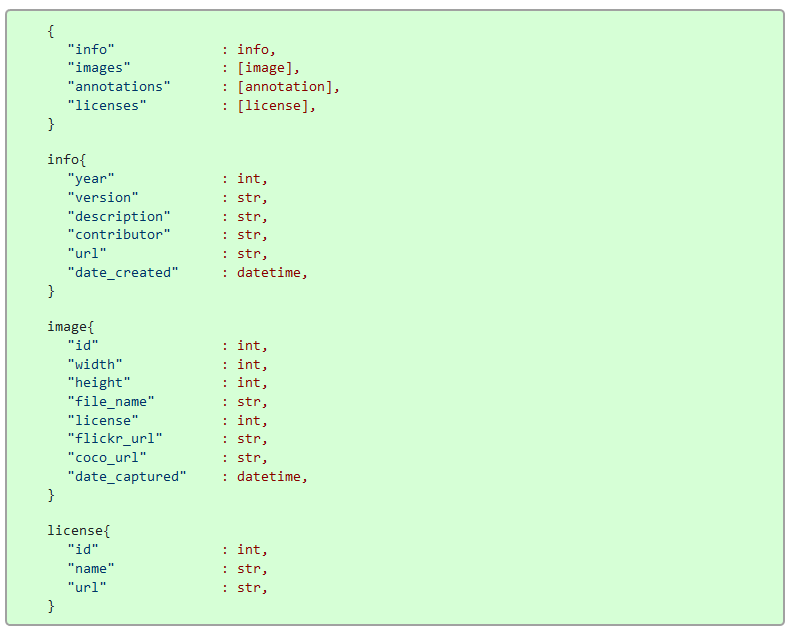

COCO Object Detection Format
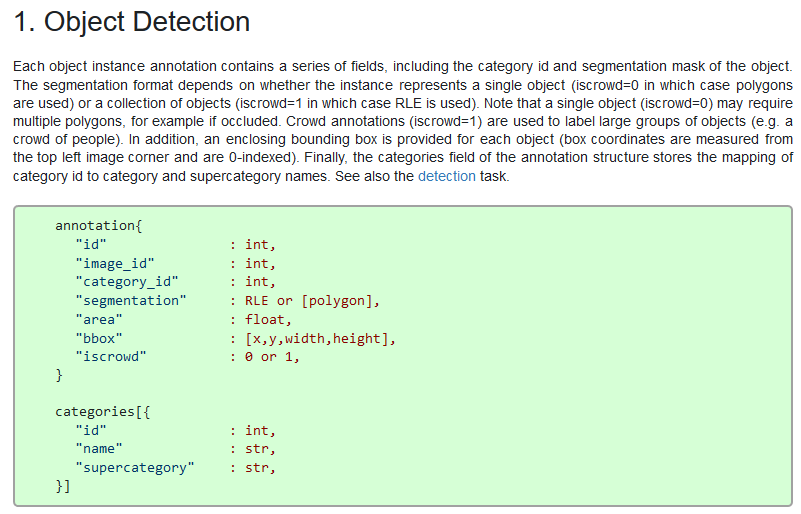

## Open Images

In [3]:
OUT_DIR = '/APL/Datasets/open-images-v5-COCO-format' 
os.makedirs(OUT_DIR, exist_ok=True)

In [4]:
OPEN_IMG = p.join('/APL/Datasets/open-images-v5')

#### Read original CSV data

In [5]:
SET = 'train'
#SET = 'validation'
#SET = 'test'

In [6]:
# Boxes
bbox_annotation = pd.read_csv(p.join(OPEN_IMG, SET + '-annotations-bbox.csv'))

In [7]:
bbox_annotation

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0
5,000002b66c9c498e,xclick,/m/01g317,1,0.320312,0.368750,0.260938,0.328125,1,0,0,0,0
6,000002b66c9c498e,xclick,/m/01g317,1,0.412500,0.945312,0.120312,0.475000,1,0,1,0,0
7,000002b66c9c498e,xclick,/m/0284d,1,0.528125,0.923437,0.675000,0.964063,0,0,0,0,0
8,000002b66c9c498e,xclick,/m/04bcr3,1,0.064062,0.492188,0.889063,0.993750,0,0,0,0,0
9,000002b66c9c498e,xclick,/m/04bcr3,1,0.301562,0.990625,0.462500,0.595312,0,0,0,0,0


In [8]:
# Image IDs
if SET == 'train':
    image_ids_csv = pd.read_csv(p.join(OPEN_IMG, SET + '-images-boxable-with-rotation.csv'))
elif SET == 'val' or SET == 'test':
    image_ids_csv = pd.read_csv(p.join(OPEN_IMG, SET + '-images-with-rotation.csv'))

In [11]:
class_desc_csv = pd.read_csv(p.join(OPEN_IMG, 'class-descriptions-boxable.csv'), header=None, names=['LabelName','HumanName'])

In [9]:
# Define basic JSON data structure
new_data_format = {'info': {'description': 'Open Images dataset',
  'url': 'https://storage.googleapis.com/openimages/web/index.html',
  'version': '5.0',
  'year': 2019,
  'contributor': 'Open Image authors, this format: Michael Smith @McGill University',
  'date_created': '2019/06/27'},
                  'images': [],
                  'annotations': [],
                  'categories': []}

In [ ]:
# Prune images we don't want
bbox_annotation2 = bbox_annotation.loc[bbox_annotation['IsDepiction'] != 1]

In [74]:
# Create image str ID to int ID mapping
im_id_mapping = {}

for im in tqdm(image_ids_csv.itertuples(), total=len(image_ids_csv)):
    im_id_mapping[im.ImageID] = im.Index

In [75]:
results = []
for i,v in tqdm(im_id_mapping.items()):
    im_filename = i + '.jpg'
    
    with Image.open(p.join(OPEN_IMG, SET, im_filename)) as image:
        im_size = image.size 
    
    results.append({'file_name': im_filename,
     'height': im_size[1],
     'width': im_size[0],
     'id': v})

/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2600: DecompressionBombWarning: Image size (102539736 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [76]:
# Create list of images with width + height and filename

def create_im_entry(i, v):
    im_filename = i + '.jpg'
    
    with Image.open(p.join(OPEN_IMG, SET, im_filename)) as image:
        im_size = image.size

    return {'file_name': im_filename,
     'height': im_size[1],
     'width': im_size[0],
     'id': v}
    
results = Parallel()(delayed(create_im_entry)(i,v) for i,v in tqdm(im_id_mapping.items()))

In [77]:
new_data_format['images'] = results

In [78]:
im_info_map = {p.splitext(i['file_name'])[0]:i for i in new_data_format['images']}    

In [79]:
im_info_map

{'2d778619f12c8aa1': {'file_name': '2d778619f12c8aa1.jpg',
  'height': 1024,
  'id': 17192,
  'width': 683},
 '29cd876cf426d9dc': {'file_name': '29cd876cf426d9dc.jpg',
  'height': 1024,
  'id': 96530,
  'width': 723},
 'dc27104fdd7cc32a': {'file_name': 'dc27104fdd7cc32a.jpg',
  'height': 768,
  'id': 98311,
  'width': 1024},
 '851230ed6c1a9ce6': {'file_name': '851230ed6c1a9ce6.jpg',
  'height': 765,
  'id': 73498,
  'width': 1024},
 'f3501ff922e67d46': {'file_name': 'f3501ff922e67d46.jpg',
  'height': 768,
  'id': 66455,
  'width': 1024},
 '34da83dae1b5e8db': {'file_name': '34da83dae1b5e8db.jpg',
  'height': 683,
  'id': 72455,
  'width': 1024},
 '12542a6cc45d52e3': {'file_name': '12542a6cc45d52e3.jpg',
  'height': 687,
  'id': 112474,
  'width': 1024},
 '9920da44a9bd2a8e': {'file_name': '9920da44a9bd2a8e.jpg',
  'height': 683,
  'id': 22731,
  'width': 1024},
 '9e8c87ce6134d939': {'file_name': '9e8c87ce6134d939.jpg',
  'height': 768,
  'id': 61291,
  'width': 1024},
 '34f046aaf4e67239

In [80]:
# Get class descriptions and create category mapping

class_label_name_to_id = {}

for cat in tqdm(class_desc_csv.itertuples()):
    
    c = {'id': cat.Index, 'name': cat.HumanName, 'supercategory': 'none'}
    
    class_label_name_to_id[cat.LabelName] = cat.Index
    
    new_data_format['categories'].append(c)

In [81]:
list_annot = []
for r in tqdm(bbox_annotation.itertuples(), total=len(bbox_annotation)):
    
    if r.IsGroupOf == 0 and r.IsDepiction == 0:
        
        im_info = im_info_map[r.ImageID]
        im_w = im_info['width']
        im_h = im_info['height']
        
        x = r.XMin * im_w
        w = (r.XMax - r.XMin) * im_w
        y = r.YMin * im_h
        h = (r.YMax - r.YMin) * im_h
        
        list_annot.append({'id': r.Index,
                     'image_id': im_info['id'],
                     'category_id': class_label_name_to_id[r.LabelName],
                     'bbox': [x, y, w, h],
                     'segmentation': [[x, y, x, y + h, x + w, y + h, x + w, y]],
                     'area': w * h,
                     'iscrowd': 0})

In [82]:
new_data_format['annotations'] = list_annot

In [83]:
new_data_format

{'annotations': [{'area': 379420.9481333146,
   'bbox': [139.88892, 157.843456, 438.05124000000006, 866.1565439999999],
   'category_id': 21,
   'id': 3,
   'image_id': 36843,
   'iscrowd': 0,
   'segmentation': [[139.88892,
     157.843456,
     139.88892,
     1024.0,
     577.9401600000001,
     1024.0,
     577.9401600000001,
     157.843456]]},
  {'area': 148070.6213332992,
   'bbox': [93.25044, 0.0, 163.54068, 905.40544],
   'category_id': 333,
   'id': 4,
   'image_id': 36843,
   'iscrowd': 0,
   'segmentation': [[93.25044,
     0.0,
     93.25044,
     905.40544,
     256.79112,
     905.40544,
     256.79112,
     0.0]]},
  {'area': 132281.00252795906,
   'bbox': [0.0, 219.486148, 525.858816, 251.552315],
   'category_id': 570,
   'id': 6,
   'image_id': 34475,
   'iscrowd': 0,
   'segmentation': [[0.0,
     219.486148,
     0.0,
     471.038463,
     525.858816,
     471.038463,
     525.858816,
     219.486148]]},
  {'area': 28790.220314318864,
   'bbox': [16.911360000000002

In [84]:
OUTPUT_JSON = p.join(OUT_DIR, SET + '.json')

In [85]:
#Output to file
with open(OUTPUT_JSON, 'w') as f:
    json.dump(new_data_format,f)